In [1]:
import os
import pandas as pd
import numpy as np

df = pd.read_csv('./data/DataSample.csv')

In [2]:
df

,_ID,TimeSt,Country,Province,City,Latitude,Longitude
0,4516516,2017-06-21 00:00:00.143,CA,ON,Waterloo,43.49347,-80.49123
1,4516547,2017-06-21 18:00:00.193,CA,ON,London,42.93990,-81.27090
2,4516550,2017-06-21 15:00:00.287,CA,ON,Guelph,43.57760,-80.22010
3,4516600,2017-06-21 15:00:00.307,CA,ON,Stratford,43.37160,-80.97730
4,4516613,2017-06-21 15:00:00.497,CA,ON,Stratford,43.37160,-80.97730
...,...,...,...,...,...,...,...
22020,5614801,2017-06-21 12:23:07.880,CA,ON,Saint Catharines,43.16440,-79.24560
22021,5614888,2017-06-21 08:23:01.793,CA,AB,Calgary,51.02093,-114.10621
22022,5614909,2017-06-21 00:23:07.903,CA,ON,Whitby,43.88730,-78.94220
22023,5614912,2017-06-21 11:23:07.953,CA,ON,Oakville,43.49340,-79.71260


<AxesSubplot:xlabel='Longitude', ylabel='Latitude'>

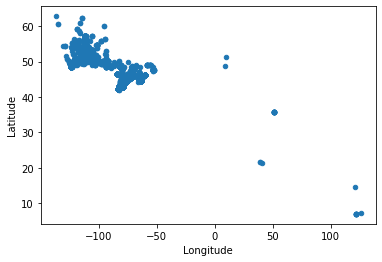

In [3]:
# Plot the coordinates
# We can roughly see the outline of Ontario/Canada in the top left
df.plot(x='Longitude', y='Latitude', kind='scatter')

In [4]:
# 1 Cleanup
# By first sorting the times, we can guarantee idential records to be grouped together
df = df.sort_values(' TimeSt')

In [5]:
dropList = list() # Keeps track of suspcious records
index = 0
for i in range(1, df.shape[0]):
    # Check if entries are equal
    if sum(df.iloc[index][1:] == df.iloc[i][1:]) == 6:
        dropList.append(i)
    else:
        index = i

df = df.drop(dropList)
df

,_ID,TimeSt,Country,Province,City,Latitude,Longitude
0,4516516,2017-06-21 00:00:00.143,CA,ON,Waterloo,43.49347,-80.49123
60,4519209,2017-06-21 00:00:01.257,CA,ON,Hanover,44.15170,-81.02660
35,4518130,2017-06-21 00:00:01.333,CA,ON,London,43.00040,-81.23430
17023,5368841,2017-06-21 00:00:02.573,CA,ON,Nepean,45.27780,-75.75630
100,4521574,2017-06-21 00:00:02.637,CA,ON,Brantford,43.15080,-80.20940
...,...,...,...,...,...,...,...
16734,5354023,2017-06-21 22:59:06.503,CA,ON,Toronto,43.67220,-79.40118
16725,5353487,2017-06-21 22:59:07.850,CA,SK,Saskatoon,52.14040,-106.60800
16934,5364292,2017-06-21 22:59:43.120,CA,AB,Edmonton,53.49723,-113.63462
16958,5365539,2017-06-21 22:59:47.540,CA,ON,Scarborough,43.77030,-79.21650


In [6]:
# Since POI1 and POI2 have the exact same coordinate, I will assume POI1 takes precedence for all occasions
# So all points will go to POI1 when labeling
# In a work position, I would definitely find clarification on something like this

poi = pd.read_csv('./data/POIList.csv')
poi

,POIID,Latitude,Longitude
0,POI1,53.546167,-113.485734
1,POI2,53.546167,-113.485734
2,POI3,45.521629,-73.566024
3,POI4,45.224830,-63.232729


In [7]:
# 2 Label
# Assign each request to POI
# Assume using geodesic distance
# Using naive approach, doesn't matter in this case with 4 total POI
import geopy.distance

poiList = []
for i in range(0, poi.shape[0]):
    poiList.append([])

for i in range(0, df.shape[0]):
    closest = 0
    dist = geopy.distance.geodesic((poi.iat[0,1], poi.iat[0,2]), (df.iat[i,5], df.iat[i,6])).km
    for poiIndex in range(1, poi.shape[0]):
        newDist = geopy.distance.geodesic((poi.iat[poiIndex,1], poi.iat[poiIndex,2]), (df.iat[i,5], df.iat[i,6])).km
        if newDist < dist:
            dist = newDist
            closest = poiIndex
    poiList[closest].append((i, dist))

In [8]:
# 3 Analysis
# First calculate average and standard deviation

for poiIndex in range(0, poi.shape[0]):
    data = [poiList[poiIndex][i][1] for i in range(0, len(poiList[poiIndex]))]
    if len(data) == 0:
        print('Average distance and standard deviation of the distance of ' + poi['POIID'][poiIndex] +' is not available')
        continue
    print('Average distance of ' + poi['POIID'][poiIndex] +' is '+str(np.mean(data)))
    print('Standard deviation of distance of ' + poi['POIID'][poiIndex] +' is '+str(np.std(data)))

Average distance of POI1 is 302.0282939290408
Standard deviation of distance of POI1 is 428.08830194658884
Average distance and standard deviation of the distance of POI2 is not available
Average distance of POI3 is 451.9766842012006
Standard deviation of distance of POI3 is 223.99666728561866
Average distance of POI4 is 514.878765316413
Standard deviation of distance of POI4 is 1522.2861519159508


In [9]:
# Next calculate the radius and density of each POI

for poiIndex in range(0, poi.shape[0]):
    data = [poiList[poiIndex][i][1] for i in range(0, len(poiList[poiIndex]))]
    if len(data) == 0:
        print('The radius and density (requests/area) of ' + poi['POIID'][poiIndex] +' is not available')
        continue
    radius = max(data)
    print('The radius of ' + poi['POIID'][poiIndex] +' is '+str(radius))
    density = len(data) / (np.pi * radius ** 2)
    print('The density (requests/area) of ' + poi['POIID'][poiIndex] +' is '+str(density))

The radius of POI1 is 11541.82947035032
The density (requests/area) of POI1 is 2.3285344311075316e-05
The radius and density (requests/area) of POI2 is not available
The radius of POI3 is 1500.453242009817
The density (requests/area) of POI3 is 0.0013828926033820443
The radius of POI4 is 9365.335692650428
The density (requests/area) of POI4 is 1.7347277509936378e-06


The number of requests assigned to POI1 is 9745
The number of requests assigned to POI1 is -1.080090101772949
The popularity of POI2 is not available
The number of requests assigned to POI3 is 9781
The number of requests assigned to POI3 is -1.027100726065817
The number of requests assigned to POI4 is 478
The number of requests assigned to POI4 is -3.60099131485782


Text(0.5, 1.0, 'Popularity of each POI from -10 to 10')

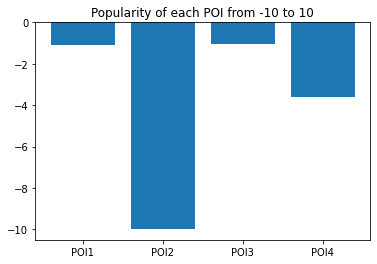

In [12]:
# 4
# Find the popularity of each POI and map them on a scale from -10 to 10
# Assuming that popularity is solely based on the number of assigned points from step 2
import matplotlib.pyplot as plt

def popularity_model(assigned, total):
    # First obtain a number in [-1,1]
    x = 2*assigned/total - 1
    if x >= 0:
        pos = True
    else:
        pos = False
    # Use cube root function to give sensivity around the average
    # Extreme cases such as if one poi had all requests would make sense because it would have a perfect score of 10
    y = pow(x, 1./3)
    r = y.real
    i = y.imag
    if pos == True:
        y = r + i
    else:
        y = r - i
    return 10*(y)

totalRequests = df.shape[0]
score = list()
for poiIndex in range(0, poi.shape[0]):
    data = [poiList[poiIndex][i][1] for i in range(0, len(poiList[poiIndex]))]
    if len(data) == 0:
        print('The popularity of ' + poi['POIID'][poiIndex] +' is not available')
        score.append(-10)
        continue
    poiClosest = len(data)
    print('The number of requests assigned to ' + poi['POIID'][poiIndex] +' is '+str(poiClosest))
    score.append(popularity_model(poiClosest, totalRequests))
    print('The number of requests assigned to ' + poi['POIID'][poiIndex] +' is '+str(score[poiIndex]))

plt.bar(poi['POIID'], score)
plt.title('Popularity of each POI from -10 to 10')

In [20]:
arr = np.array(df[' TimeSt'])

In [33]:
print(sum(arr > '2017-06-21 01:00:00'))
print(sum(arr > '2017-06-21 03:00:00'))
print(sum(arr > '2017-06-21 05:00:00'))
print(sum(arr > '2017-06-21 07:00:00'))
print(sum(arr > '2017-06-21 09:00:00'))
print(sum(arr > '2017-06-21 11:00:00'))
print(sum(arr > '2017-06-21 13:00:00'))
print(sum(arr > '2017-06-21 15:00:00'))
print(sum(arr > '2017-06-21 17:00:00'))
print(sum(arr > '2017-06-21 19:00:00'))
print(sum(arr > '2017-06-21 21:00:00'))
print(sum(arr > '2017-06-21 23:00:00'))

19179
17453
15750
14056
12282
10507
8722
6988
5289
3539
1802
0
